In [ ]:
# Operating system interfaces
import os 
# Library for real-time computer vision
import cv2
# Plot library
import matplotlib.pyplot as plt
# Operations on matrices
import numpy as np
# Deep learning library
import tensorflow as tf
# Track time
import time
# Pandas table dataframes
import pandas as pd
# Plot movie frames on Google Colab
from google.colab.patches import cv2_imshow

# Install and import EfficientNet
!pip install EfficientNet
from efficientnet.tfkeras import EfficientNetB0

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!rm -rf images
!mkdir images
!du -hs images

cap = cv2.VideoCapture('/content/drive/My Drive/Trento/Data/500days.mp4')

path = '/content/images'


for i in range(0,int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), int(cap.get(cv2.CAP_PROP_FPS))):
  
    ret, frame = cap.read()

    # Resize the 1280 x 720 resolution frames to 398 x 224 (to maintain ratio)
    # Then clip the frames to get 224 x 224 CNN inputs

    dim = (398, 224)

    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    crop_img = resized[: , int(87):int(311)]

    if ret == False:
        break
    cv2.imwrite(os.path.join(path, str(i) +'.jpg'), crop_img)
 
cap.release()
cv2.destroyAllWindows()

4.0K	images


In [ ]:
model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


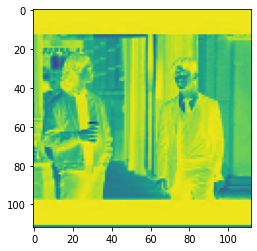

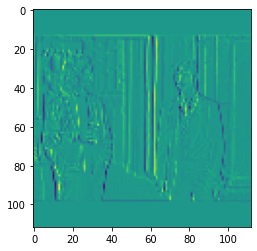

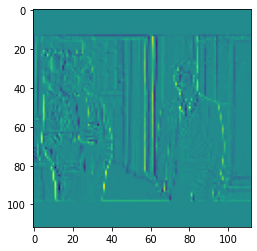

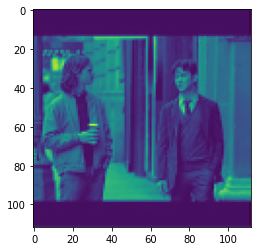

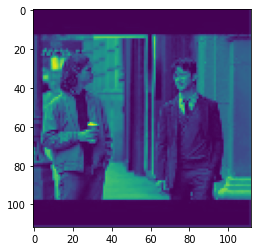

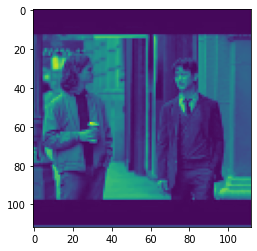

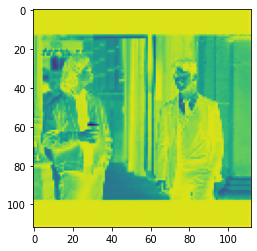

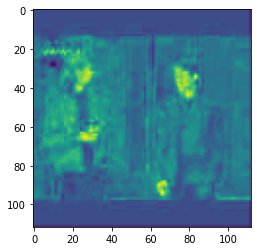

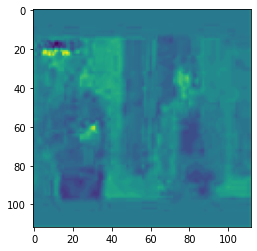

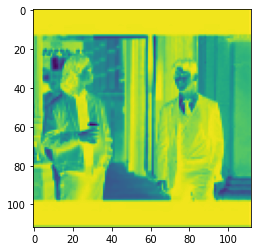

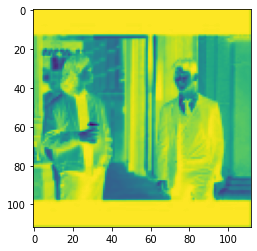

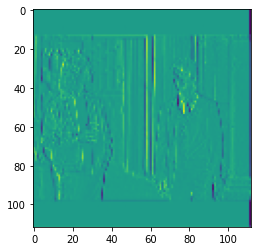

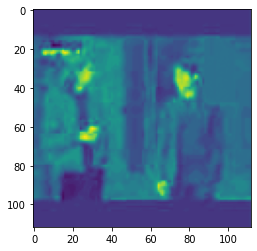

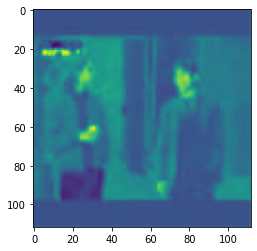

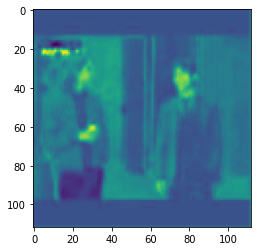

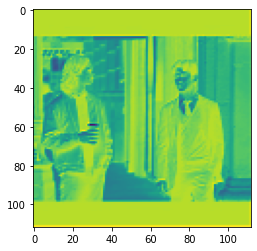

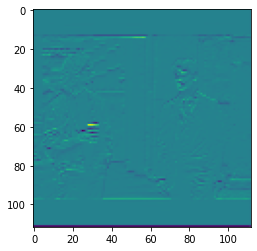

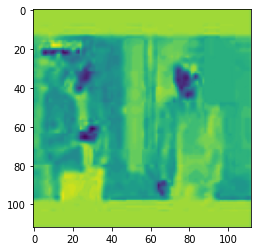

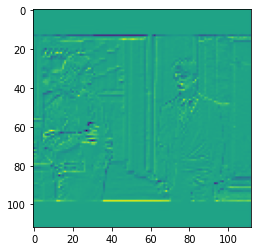

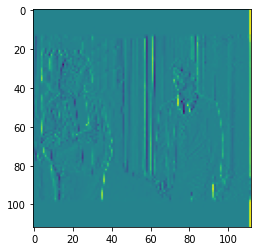

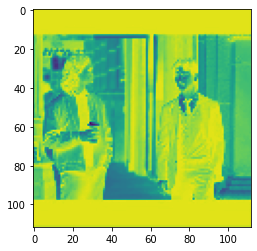

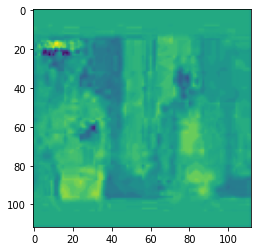

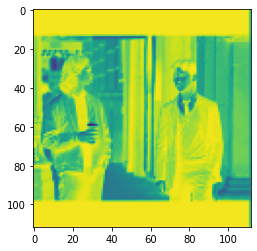

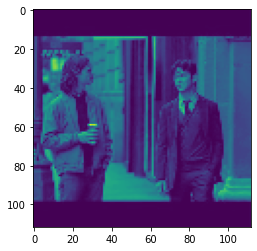

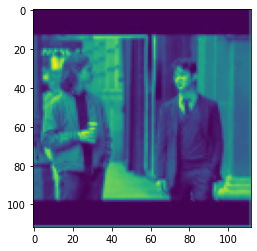

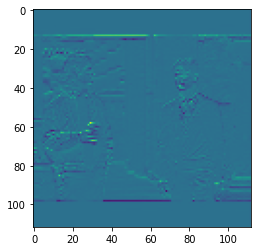

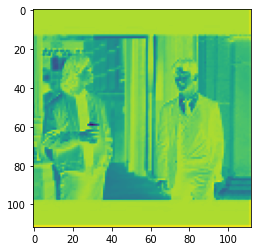

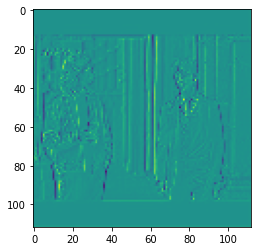

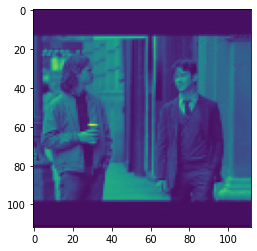

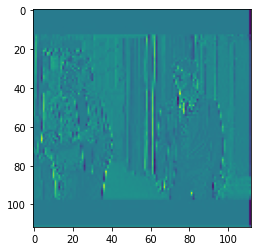

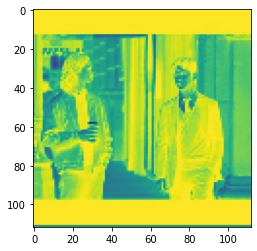

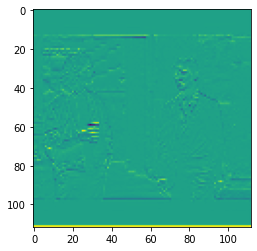

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = EfficientNetB0()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img('/content/images/0.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# # plot all 32 maps
for i in range(0,32):
  pyplot.imshow(feature_maps[0, :, :, i])
  pyplot.show()

In [ ]:
j=0
fmaps= np.zeros((621,1, 112, 112, 32))

for i in range(0,18630,30):

  # load the image with the required shape
  img = load_img("/content/images/" + str(i) + ".jpg", target_size=(224, 224))
  # convert the image to an array
  img = img_to_array(img)
  # expand dimensions so that it represents a single 'sample'
  img = expand_dims(img, axis=0)
  # prepare the image (e.g. scale pixel values)
  img = preprocess_input(img)
  # get feature map for first hidden layer
  fmaps[j] = model.predict(img)
  j+=1

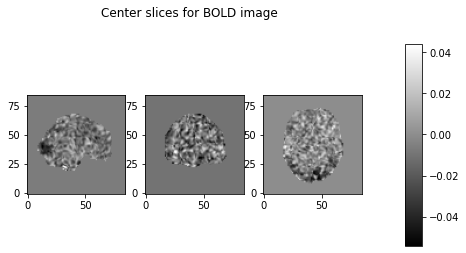

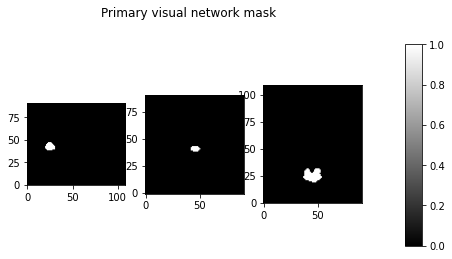

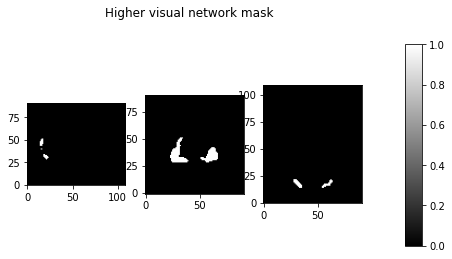

In [ ]:
# Load the BOLD image dataset
import nibabel as nib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

img = nib.load('/content/drive/My Drive/Trento/Data/500daysclip_fMRI.nii.gz')
img = img.get_fdata()

def show_slices(slices, color):
   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       im = axes[i].imshow(slice.T, cmap=color, origin="lower")
       cbar_ax = fig.add_axes([1.0, 0.15, 0.04, 0.7])
       
       if i == 2:
         fig.colorbar(im, cax=cbar_ax)

slice_0 = img[42, :, :, 0]
slice_1 = img[:, 42, :, 0]
slice_2 = img[:, :, 42, 0]
show_slices([slice_0, slice_1, slice_2], color='gray')
plt.suptitle("Center slices for BOLD image");

# Functional network masks obtained from:
# https://findlab.stanford.edu/functional_ROIs.html

mask1 = nib.load('/content/drive/My Drive/Trento/Data/primary_visual.nii')
mask1 = mask1.get_fdata()
mask1 = np.asarray(mask1)

slice_0 = mask1[42, :, :]
slice_1 = mask1[:, 20, :]
slice_2 = mask1[:, :, 42]
show_slices([slice_0, slice_1, slice_2], color='gray')
plt.suptitle("Primary visual network mask");

mask2 = nib.load('/content/drive/My Drive/Trento/Data/higher_visual.nii')
mask2 = mask2.get_fdata()
mask2 = np.asarray(mask2)

slice_0 = mask2[36, :, :]
slice_1 = mask2[:, 20, :]
slice_2 = mask2[:, :, 42]
show_slices([slice_0, slice_1, slice_2], color='gray')
plt.suptitle("Higher visual network mask");

In [ ]:
fmaps.shape

(621, 1, 112, 112, 32)

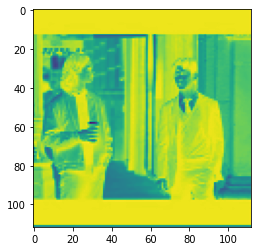

(600, 1, 112, 112)

In [ ]:
# Test the first feature map. Try different ones (some of them look similar)
pyplot.imshow(fmaps[0, 0, :, :, 0])
pyplot.show()

onefmap = fmaps[:600, :, :, :, 0]
onefmap.shape

In [ ]:
import math
from sklearn.model_selection import train_test_split # data split
from sklearn.linear_model import Ridge # Regression algorithm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error # evaluation metric
from scipy.stats import pearsonr

dim1 = img.shape[0]
dim2 = img.shape[1]
dim3 = img.shape[2]

ccoef = np.zeros(32)

# Partition screen into 5x5 subframes
R = np.zeros((dim1, dim2, dim3, 5, 5, 32))

for i in range(0, dim1):
  for j in range(0, dim2):
    for k in range(0, dim3):
      if mask1[i,j,k] != 0:

        y = img[i,j,k,:]

        
        for w in range(5):
          for s in range(5):

           for f in range(32):
              R[i, j, k, w, s, f] = pearsonr(fmaps[:600,0,w*20,s*20,f], y[:600])[0]

In [ ]:
where_are_NaNs = np.isnan(R)
R[where_are_NaNs] = 0
R1 = R.reshape(85*85*85,5,5,32)
nonzeroind = np.unique(np.nonzero(R1)[0])
# Top-right = Q1
# Top-left = Q2
# Bottom-left = Q3
# Bottom-right = Q4
# Center = C

p = 0

list = [[]]

for i in nonzeroind:

  R2 = R1[i,:,:,:]

  coord = np.unravel_index(R2.argmax(), R2.shape)
  v1 = coord[0] - 2
  v2 = coord[1] - 2
  
  if coord[0] > 2 and coord[1] > 2:
    list.append([p,'Q1', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  if coord[0] < 2 and coord[1] > 2:
    list.append([p,'Q2', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  if coord[0] < 2 and coord[1] < 2:
    list.append([p,'Q3', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  if coord[0] > 2 and coord[1] < 2:
    list.append([p,'Q4', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  list.append([p,'C', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
  p += 1
  
import pandas as pd

df = pd.DataFrame(list,columns=['Voxel','Screen region','Angle','Radius','Feature map', 'R'])[1:]
df

,Voxel,Screen region,Angle,Radius,Feature map,R
1,0.0,C,90.000000,2.000000,5.0,0.162954
2,1.0,Q4,-26.565051,2.236068,31.0,0.148517
3,2.0,Q3,-116.565051,2.236068,2.0,0.193199
4,3.0,C,-90.000000,1.000000,1.0,0.126423
5,4.0,C,-90.000000,1.000000,27.0,0.136011
...,...,...,...,...,...,...
1116,1115.0,C,0.000000,0.000000,18.0,0.105893
1117,1116.0,Q2,116.565051,2.236068,25.0,0.212185
1118,1117.0,C,0.000000,0.000000,25.0,0.100137
1119,1118.0,Q2,116.565051,2.236068,25.0,0.112594


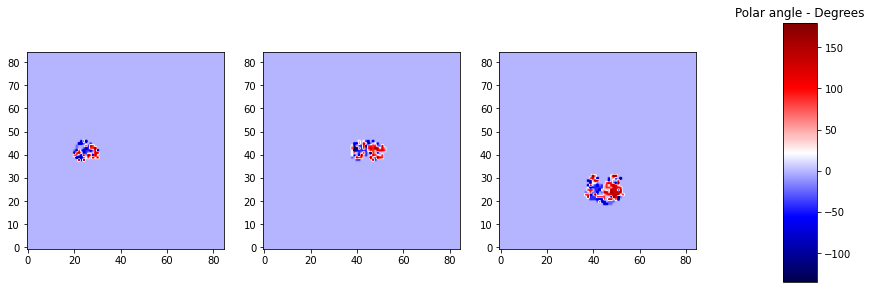

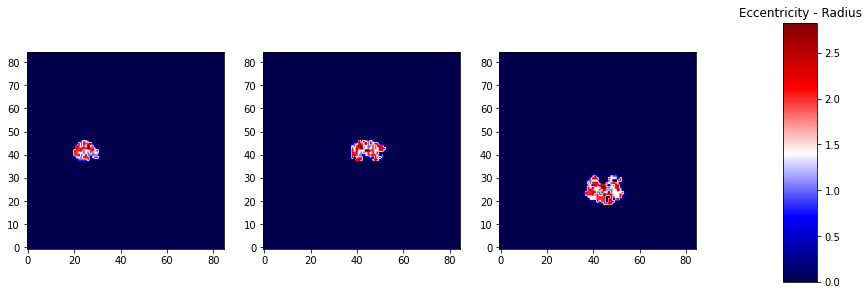

In [ ]:
RA = np.zeros((dim1, dim2, dim3))
RE = np.zeros((dim1, dim2, dim3))

c = 0

for i in range(0, dim1):
  for j in range(0, dim2):
    for k in range(0, dim3):

      if mask1[i,j,k] != 0:
        if c == df.shape[0]:
          break

        RA[i, j, k] = df.iloc[c,2]
        RE[i, j, k] = df.iloc[c,3]

        c +=1

import seaborn as sns

def show_slices(slices, color):
   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       im = axes[i].imshow(slice.T, cmap=color, origin="lower")
       fig.set_size_inches(12,12)
       cbar_ax = fig.add_axes([1.0, 0.35, 0.04, 0.3])
       if i == 2:
         fig.colorbar(im, cax=cbar_ax)
         
for k in range(1):
  slice_0 = RA[42, :, :]
  slice_1 = RA[:, 26, :]
  slice_2 = RA[:, :, 42]
  show_slices([slice_0, slice_1, slice_2], color='seismic')
  plt.title("Polar angle - Degrees");

  slice_0 = RE[42, :, :]
  slice_1 = RE[:, 26, :]
  slice_2 = RE[:, :, 42]
  show_slices([slice_0, slice_1, slice_2], color='seismic')
  plt.title("Eccentricity - Radius");

In [ ]:
dim1 = img.shape[0]
dim2 = img.shape[1]
dim3 = img.shape[2]

ccoef = np.zeros(32)

# Partition screen into 5x5 subframes
R = np.zeros((dim1, dim2, dim3, 5, 5, 32))

for i in range(0, dim1):
  for j in range(0, dim2):
    for k in range(0, dim3):
      if mask2[i,j,k] != 0:

        y = img[i,j,k,:]

        
        for w in range(5):
          for s in range(5):
           for f in range(32):
             
              R[i, j, k, w, s, f] = pearsonr(fmaps[:600,0,w*20,s*20,f], y[:600])[0]

In [ ]:
where_are_NaNs = np.isnan(R)
R[where_are_NaNs] = 0
R1 = R.reshape(85*85*85,5,5,32)
nonzeroind = np.unique(np.nonzero(R1)[0])
# Top-right = Q1
# Top-left = Q2
# Bottom-left = Q3
# Bottom-right = Q4
# Center = C

p = 0

list = [[]]

for i in nonzeroind:

  R2 = R1[i,:,:,:]

  coord = np.unravel_index(R2.argmax(), R2.shape)
  v1 = coord[0] - 2
  v2 = coord[1] - 2
  
  if coord[0] > 2 and coord[1] > 2:
    list.append([p,'Q1', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  if coord[0] < 2 and coord[1] > 2:
    list.append([p,'Q2', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  if coord[0] < 2 and coord[1] < 2:
    list.append([p,'Q3', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  if coord[0] > 2 and coord[1] < 2:
    list.append([p,'Q4', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
    p += 1
    continue

  list.append([p,'C', np.angle(v1+v2*1j, deg=True), np.sqrt(v1**2+v2**2), coord[2], R2[coord]])
  p += 1
  
import pandas as pd

df = pd.DataFrame(list,columns=['Voxel','Screen region','Angle','Radius','Feature map','R'])[1:]
df

,Voxel,Screen region,Angle,Radius,Feature map,R
1,0.0,C,0.000000,0.000000,19.0,0.233629
2,1.0,Q3,-116.565051,2.236068,1.0,0.236205
3,2.0,Q2,116.565051,2.236068,1.0,0.226903
4,3.0,C,0.000000,0.000000,29.0,0.163306
5,4.0,Q1,26.565051,2.236068,28.0,0.288646
...,...,...,...,...,...,...
1946,1945.0,C,-90.000000,1.000000,27.0,0.218512
1947,1946.0,C,-90.000000,1.000000,27.0,0.224149
1948,1947.0,C,180.000000,1.000000,17.0,0.221301
1949,1948.0,Q1,45.000000,2.828427,12.0,0.225368


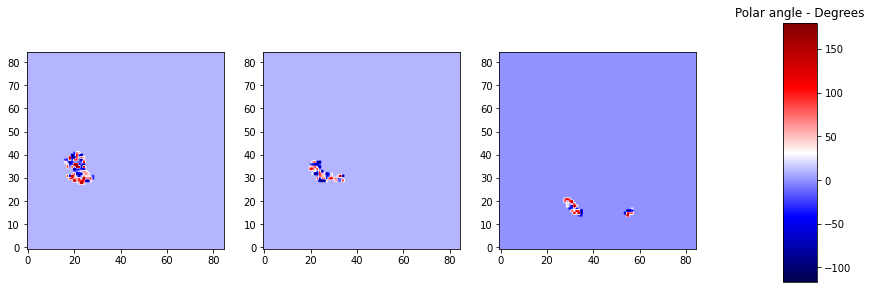

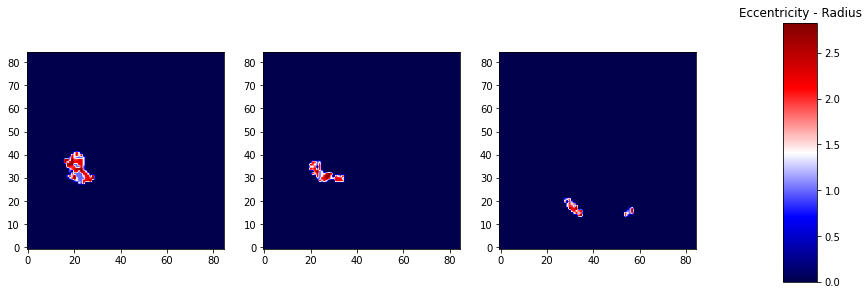

In [ ]:
RA = np.zeros((dim1, dim2, dim3))
RE = np.zeros((dim1, dim2, dim3))

c = 0

for i in range(0, dim1):
  for j in range(0, dim2):
    for k in range(0, dim3):

      if mask2[i,j,k] != 0:
        if c == df.shape[0]:
          break

        RA[i, j, k] = df.iloc[c,2]
        RE[i, j, k] = df.iloc[c,3]

        c +=1

import seaborn as sns

def show_slices(slices, color):
   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       im = axes[i].imshow(slice.T, cmap=color, origin="lower")
       fig.set_size_inches(12,12)
       cbar_ax = fig.add_axes([1.0, 0.35, 0.04, 0.3])
       if i == 2:
         fig.colorbar(im, cax=cbar_ax)
         
for k in range(1):
  slice_0 = RA[26, :, :]
  slice_1 = RA[:, 26, :]
  slice_2 = RA[:, :, 42]
  show_slices([slice_0, slice_1, slice_2], color='seismic')
  plt.title("Polar angle - Degrees");

  slice_0 = RE[26, :, :]
  slice_1 = RE[:, 26, :]
  slice_2 = RE[:, :, 42]
  show_slices([slice_0, slice_1, slice_2], color='seismic')
  plt.title("Eccentricity - Radius");